# Explainable Boosting Machine (EBM)

EBMs belong to the family of Generative Additive Models (GAM).EBM is a glassbox model, designed to have accuracy comparable to state-of-the-art machine learning methods like Random Forest and Boosted Trees, while being highly intelligibile and explainable. 


## **1. Import libraries and Dataset**

In [26]:
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns



data = pd.read_csv('../../Post-hoc/datasets/diabetes_130/diabetic_data.csv')
X = data.drop(columns=['readmitted'])
#we will chnage this to a binarry classification problem. 
#We will consider readmitted as a positive class if the patient was readmitted within 30 days or after 30 days
y = data['readmitted'].apply(lambda x: 'YES' if x in ['<30', '>30'] else 'NO')
feature_names = X.columns.tolist()

#missing values will be changed to extreme values like -1000
# we will not impute the missing values because that will affect the shape functions computed by EBM
X = X.fillna(-1000)

# we will convert the categorical variables to one-hot encoding
X = pd.get_dummies(X)

# we will drop the columns that have only one unique value
X = X.drop(columns=['examide_No', 'citoglipton_No'])

# we will drop patient_nbr because it is a unique identifier and encounter_id because it is a random number
X = X.drop(columns=['patient_nbr', 'encounter_id'])

# use label encoder to change YES to1 and NO to 0
y = y.apply(lambda x: 1 if x == 'YES' else 0)


df = pd.DataFrame(X)
display(df.head())
print(y.value_counts())


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,6,25,1,1,41,0,1,0,0,0,...,True,False,True,False,True,False,False,True,True,False
1,1,1,7,3,59,0,18,0,0,0,...,True,False,True,False,True,False,True,False,False,True
2,1,1,7,2,11,5,13,2,0,1,...,True,False,True,False,True,False,False,True,False,True
3,1,1,7,2,44,1,16,0,0,0,...,True,False,True,False,True,False,True,False,False,True
4,1,1,7,1,51,0,8,0,0,0,...,True,False,True,False,True,False,True,False,False,True


readmitted
0    54864
1    46902
Name: count, dtype: int64


## **3. Train and validate the EBM model.**

We will use the `Interpret.ml` toolkit which includes the official implementation of EBMs. Uisng the toolkit is very simple and straightforward as you will see...

In [ ]:
import os
import joblib


def train_or_load_ebm(X, y, model_path='ebm_model.pkl', pretrained=False):
    if pretrained and os.path.exists(model_path):
        ebm = joblib.load(model_path)
        print("Loaded pretrained model.")
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

        # Train EBM with feature names
        ebm = ExplainableBoostingClassifier(feature_names=X.columns, random_state=42)
        ebm.fit(X_train, y_train)

        # Save the model
        joblib.dump(ebm, model_path)
        print("Trained and saved new model.")

        # Predict probabilities and classes for the test set
        y_pred_proba = ebm.predict_proba(X_test)[:, 1]
        y_pred = ebm.predict(X_test)

        # Calculate metrics
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot ROC Curve
        axes[0].plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc_roc:.2f}')
        axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve')
        axes[0].legend()

        # Plot Confusion Matrix
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Actual')
        axes[1].set_title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

        print(f'Accuracy: {accuracy:.2f}')
        print(f'Sensitivity (Recall): {sensitivity:.2f}')
        print(f'Specificity: {specificity:.2f}')

    return ebm

# Example usage:
# ebm_model = train_or_load_ebm(X, y, pretrained=False)


KeyboardInterrupt: 

The results indicate that the EBM model performs exceptionaly well on this dataset. The toolkit provides tools for interactive visualization of shape functions for each feature and heatmaps (for 2nd order interactions between features).

## **4. Explain the model**

We will first use the built-in `Interpret.ml` toolkit funcionality for visualizing the global model explanation feature-wise explanations.

In [8]:

global_explanation = ebm.explain_global()
show(global_explanation)

<!-- http://127.0.0.1:7001/5754063552/ -->

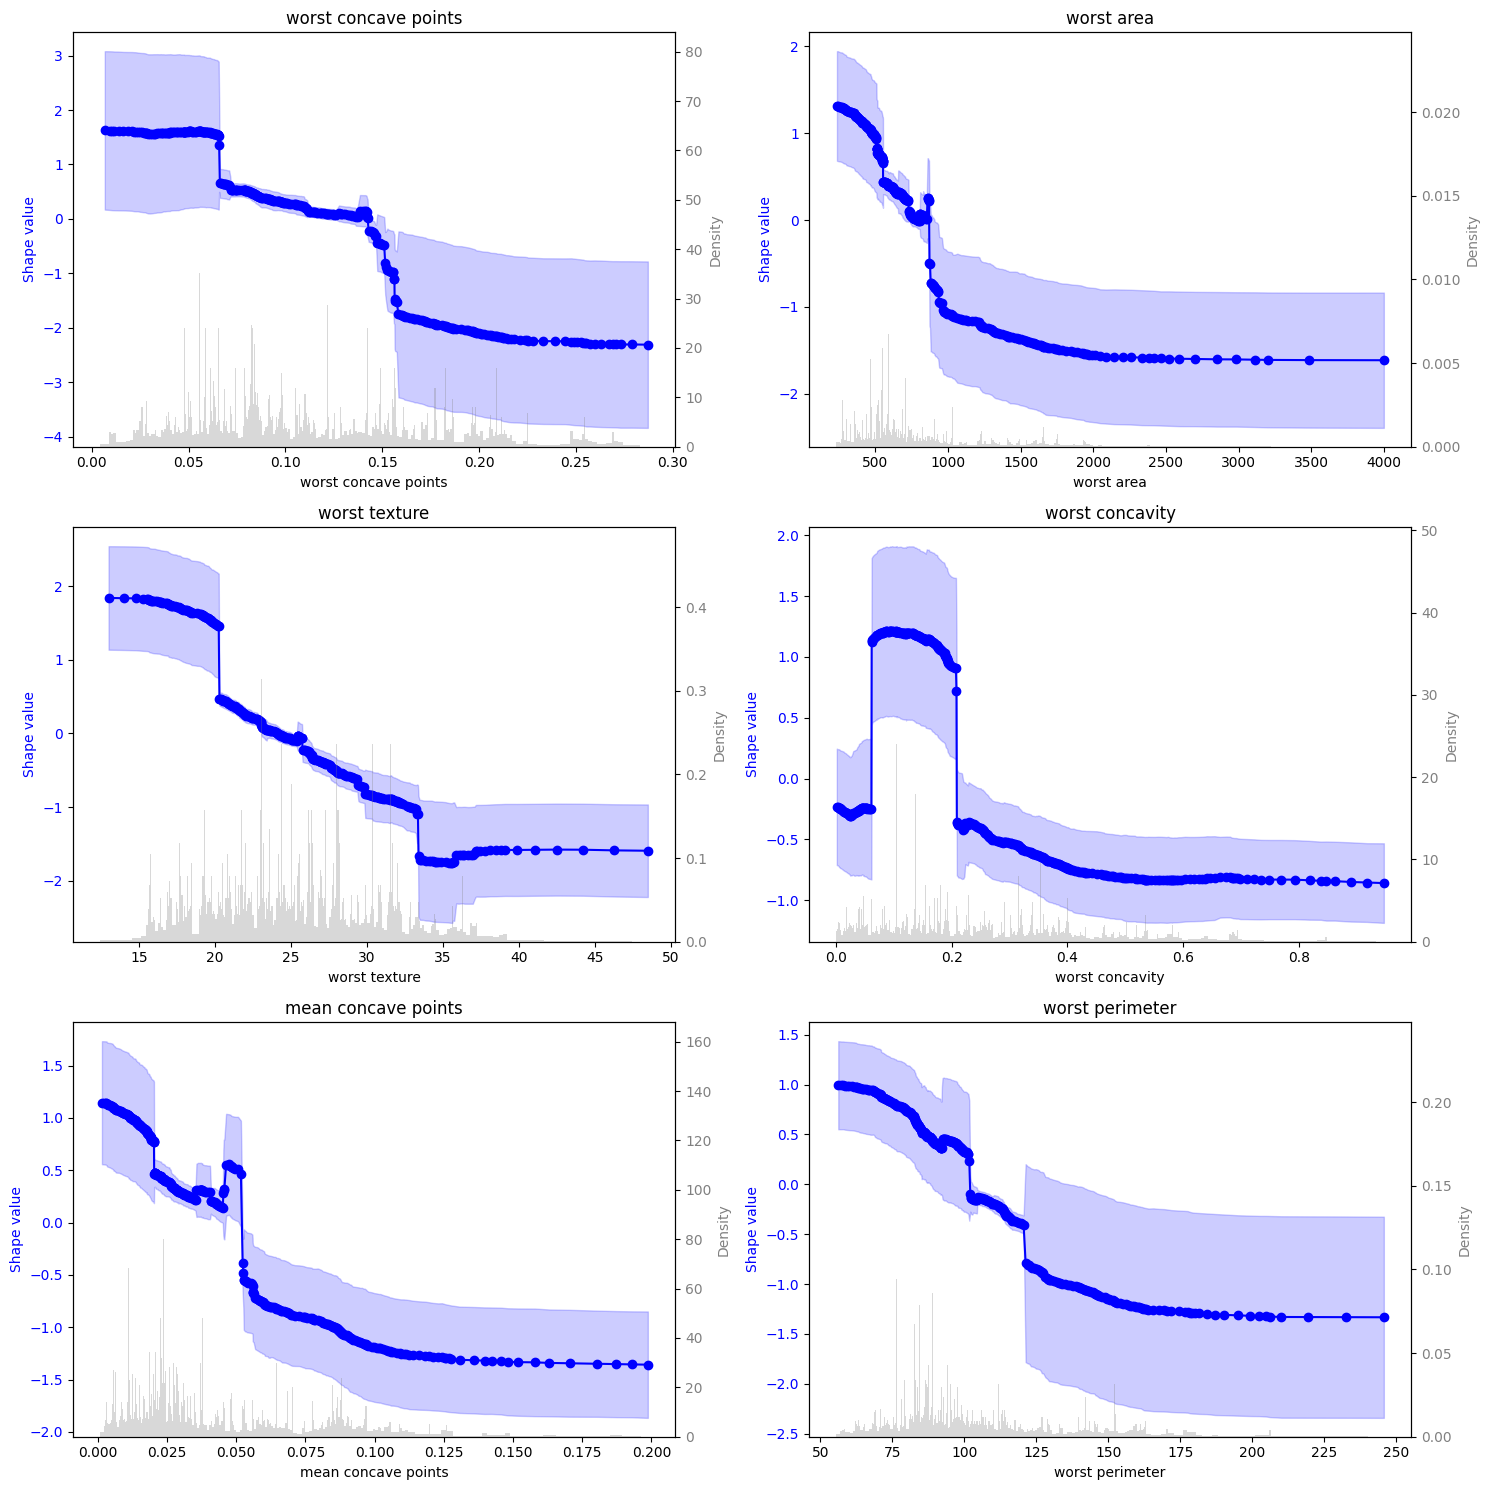

In [54]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier

# 1. Load the breast cancer dataset and get feature names
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names  # actual names

# 2. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. Train an Explainable Boosting Classifier using the actual feature names.
ebm = ExplainableBoostingClassifier(feature_names=feature_names, random_state=42)
ebm.fit(X_train, y_train)

# 4. Get term importances and select the top six univariate (main effect) terms.
importances = ebm.term_importances(importance_type="avg_weight")
term_names = np.array(ebm.term_names_)
term_features = ebm.term_features_

# Filter for main effects (terms with one feature only)
main_effect_indices = [i for i, tf in enumerate(term_features) if len(tf) == 1]
main_importances = [(i, importances[i]) for i in main_effect_indices]
main_importances_sorted = sorted(main_importances, key=lambda x: abs(x[1]), reverse=True)

# Select the top six term indices and their names.
top6 = main_importances_sorted[:6]
top6_indices = [t[0] for t in top6]
top6_names = [term_names[i] for i in top6_indices]

# 5. Create a 3x2 grid of subplots.
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

# For each of the six selected terms, plot the shape function and feature histogram.
for idx, term_idx in enumerate(top6_indices):
    feature_idx = ebm.term_features_[term_idx][0]
    bins = ebm.bins_[feature_idx][0]
    shape_vals = ebm.term_scores_[term_idx]
    std_vals = ebm.standard_deviations_[term_idx]  # confidence intervals, if available

    ax = axes[idx]
    
    if isinstance(bins, np.ndarray):
        bounds = ebm.feature_bounds_[feature_idx]  # [min, max] for the feature
        bin_edges = np.concatenate(([bounds[0]], bins, [bounds[1]]))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Remove the first bin ("0" bin)
        bin_centers = bin_centers[1:]
        shape_vals = shape_vals[1:]
        if std_vals is not None:
            std_vals = std_vals[1:]
        # Ensure lengths match
        min_length = min(len(bin_centers), len(shape_vals), len(std_vals) if std_vals is not None else len(shape_vals))
        bin_centers = bin_centers[:min_length]
        shape_vals = shape_vals[:min_length]
        if std_vals is not None:
            std_vals = std_vals[:min_length]
        # For histogram, use the remaining bin edges (drop the first and last edge)
        new_bin_edges = bin_edges[1:-1]
    else:
        bin_centers = list(bins.keys())
        if bin_centers and bin_centers[0] == 0:
            bin_centers = bin_centers[1:]
            shape_vals = shape_vals[1:]
            if std_vals is not None:
                std_vals = std_vals[1:]
        new_bin_edges = None

    # Plot the shape function.
    ax.plot(bin_centers, shape_vals, marker='o', linestyle='-', color='blue',
            label='Shape function')
    # Instead of error bars, fill the area between (shape_vals - std_vals) and (shape_vals + std_vals)
    if std_vals is not None:
        lower = shape_vals - std_vals
        upper = shape_vals + std_vals
        ax.fill_between(bin_centers, lower, upper, color='blue', alpha=0.2)
    
    ax.set_xlabel(feature_names[feature_idx])
    ax.set_ylabel("Shape value", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(top6_names[idx])
    
    # Create a twin axis for the feature histogram.
    ax2 = ax.twinx()
    feat_data = X_train[:, feature_idx]
    if new_bin_edges is not None:
        ax2.hist(feat_data, bins=new_bin_edges, color='gray', alpha=0.3,
                 density=True, label='Feature density')
    else:
        values, counts = np.unique(feat_data, return_counts=True)
        ax2.bar(values, counts / np.sum(counts), color='gray', alpha=0.3,
                label='Feature density')
    ax2.set_ylabel("Density", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

plt.tight_layout()
plt.show()